<a href="https://colab.research.google.com/github/VegaSera/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/Wesley_Mountford_LS_DS12_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [x] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [x] Begin with baselines for classification.
- [X] Use scikit-learn for logistic regression.
- [X] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [X] Get your model's test accuracy. (One time, at the end.)
- [X] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [X] Do one-hot encoding.
- [X] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [X] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
import numpy as np
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
df['Date'] = pd.to_datetime(df['Date']) #Make sure our dates are in the proper format

In [0]:
mapdict = {'x':1, 'X':1, 'Yes':1, 'yes':1, 'No':0, 'no':0, np.NaN:0}
ingredients = ['Chips', 'Beef', 'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream',
               'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice', 'Beans', 'Lettuce', 
               'Tomato', 'Bell peper', 'Carrots', 'Cabbage', 'Sauce', 'Salsa.1',
               'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham', 'Chile relleno', 
               'Nopales', 'Lobster', 'Queso', 'Egg', 'Mushroom', 'Bacon', 'Sushi', 
               'Avocado', 'Corn', 'Zucchini', 'Unreliable', 'NonSD']
for col in ingredients:
  df[col] = df[col].map(mapdict)

In [0]:
import category_encoders as ce
enc = ce.OneHotEncoder(use_cat_names=True)
df = enc.fit_transform(df)

In [10]:
df.head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,1,0,0,0,0,2016-01-18,3.5,4.2,0,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
1,1,0,0,0,0,2016-01-24,3.5,3.3,0,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,0,1,0,0,0,2016-01-24,NaN,NaN,0,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
3,0,0,1,0,0,2016-01-24,NaN,NaN,0,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
4,1,0,0,0,0,2016-01-27,4.0,3.8,1,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True


In [11]:
test_2018 = df[df['Date'] >= pd.to_datetime('2018-01-01')]
validate_2017 = df[(df['Date'] < pd.to_datetime('2018-01-01'))&(df['Date'] >= pd.to_datetime('2017-01-01'))]
train = df[df['Date'] < pd.to_datetime('2017-01-01')]
print(test_2018.shape, validate_2017.shape, train.shape)

(38, 63) (85, 63) (298, 63)


In [0]:
target = 'Great'
y_train = train[target]

#Testing our baseline, which is that all burritos are not great. (This is considered heresy in some cultures.)
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)
#Our baseline accuracy score, assuming all burritos are not great, is 59.06%

0.5906040268456376

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

#In addition to the above listed ingredients list, these are for making quick changes to the dropped features.
ratings = ['Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Cost', 'Hunger', 'Yelp', 'Google']
other = ['Circum', 'Length', 'Volume']
burritos = ['Burrito_California', 'Burrito_Carnitas', 'Burrito_Asada', 'Burrito_Other', 'Burrito_Surf & Turf']

#Mass and density are dropped because they kept giving me strange errors.
features = df.columns.drop(['Date', 'Great', 'Mass (g)', 'Density (g/mL)']+ingredients) 

X_train = train[features]
y_train = train[target]
X_val = validate_2017[features]
y_val = validate_2017[target]
X_test = test_2018[features]
y_test = test_2018[target]

In [167]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model = LogisticRegressionCV(cv=15,max_iter=1200)
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=15, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1200, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [168]:
print('Accuracy', model.score(X_val_scaled, y_val))

Accuracy 0.8470588235294118


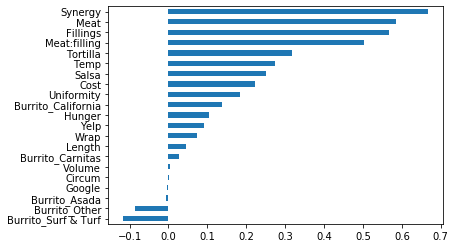

In [169]:
coefficients = pd.Series(model.coef_[0], X_train.columns)
coefficients.sort_values().plot.barh();

In [170]:
X_test = test_2018[features]
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)

model.score(X_test_scaled, y_test)
#Better than our baseline, not the 87% I expected.

0.7631578947368421